In [101]:
%load_ext autoreload
%autoreload 2

from typing import Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import sys 
import seaborn as sns
import math
import statsmodels.api as sm

sys.path.append('../../modules')
import eumf_data, eumf_pipeline, eumf_eval

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()


In [19]:
country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)


In [41]:
country_selection = ["PL", "RO", "BG", "IT", "HU", "HR", "GR", "ES", "FR"]

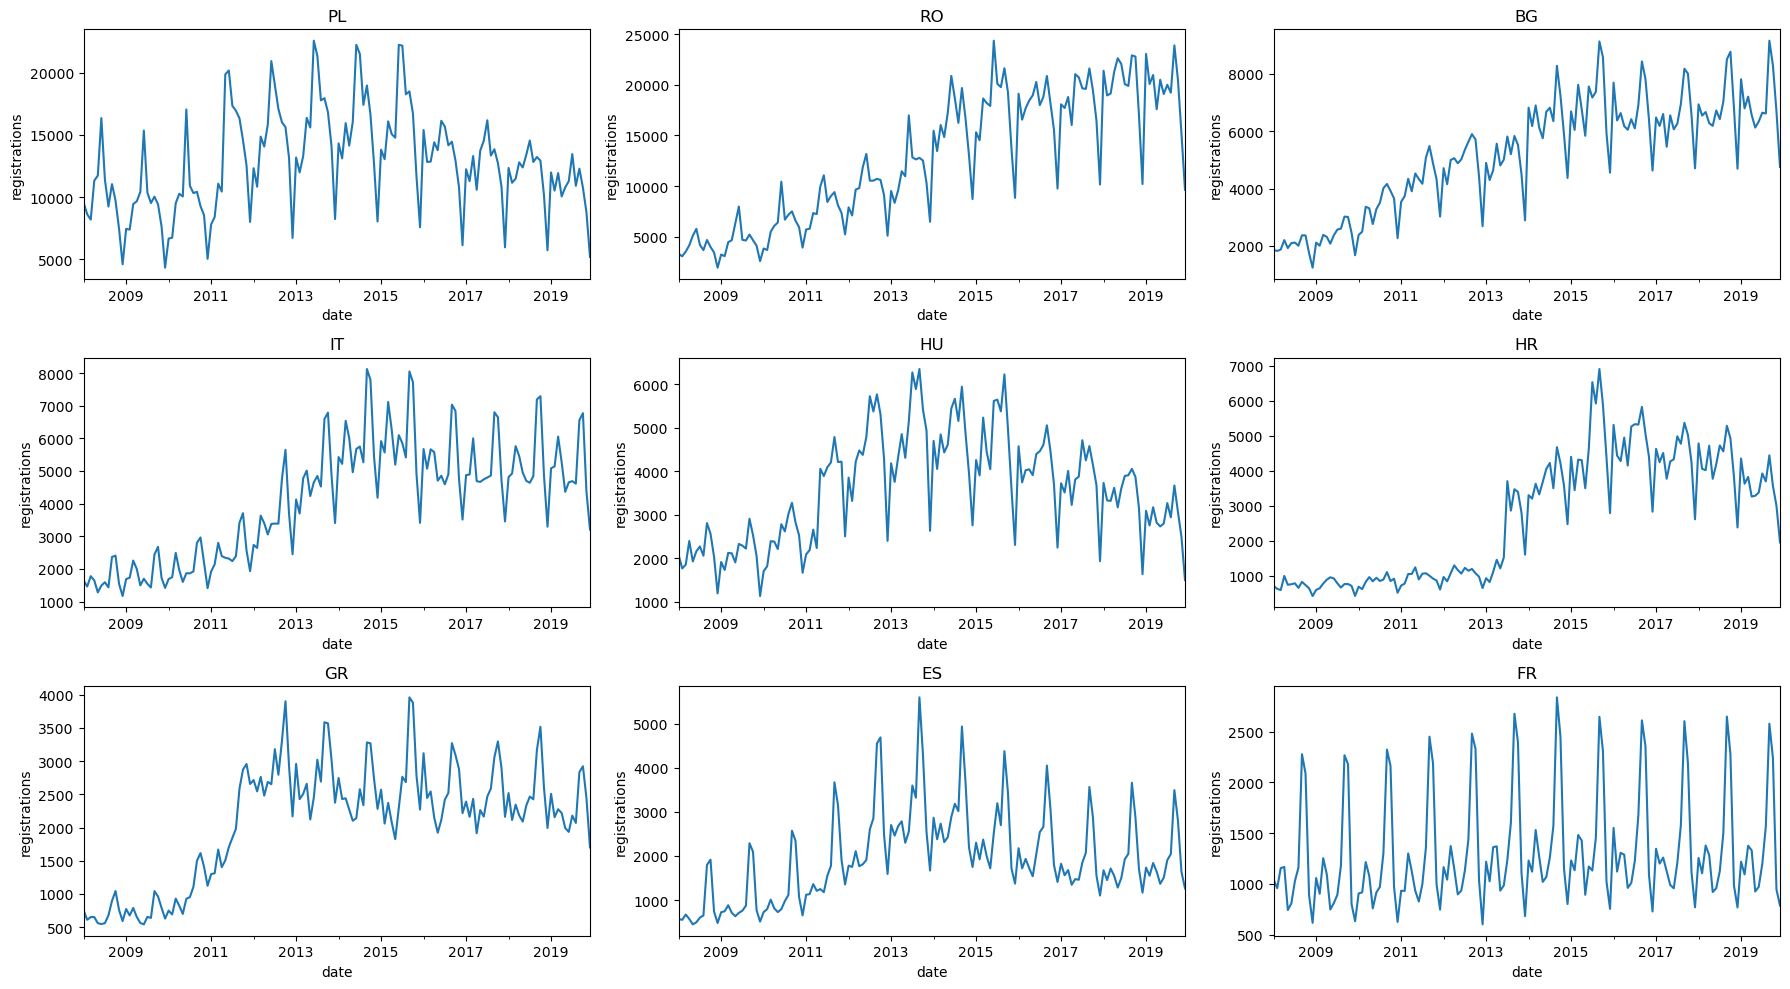

In [43]:
eumf_eval.plot_panel(
    df_values,
    n_rows=3,
    n_cols=3,
    figsize=(18, 10),
    legend=None,
    ylabel="registrations",
    countries=country_selection,
)
plt.show()


In [108]:
df_values_transformed = np.log(df_values) - np.log(df_values.shift(12))
df_trends_transformed = np.log(df_trends) - np.log(df_trends.shift(12))
panel_transformed = np.log(panel + 0.1) - np.log(panel.shift(12) + 0.1)
panel_3m_transformed = np.log(panel_3m) - np.log(panel_3m.shift(4))

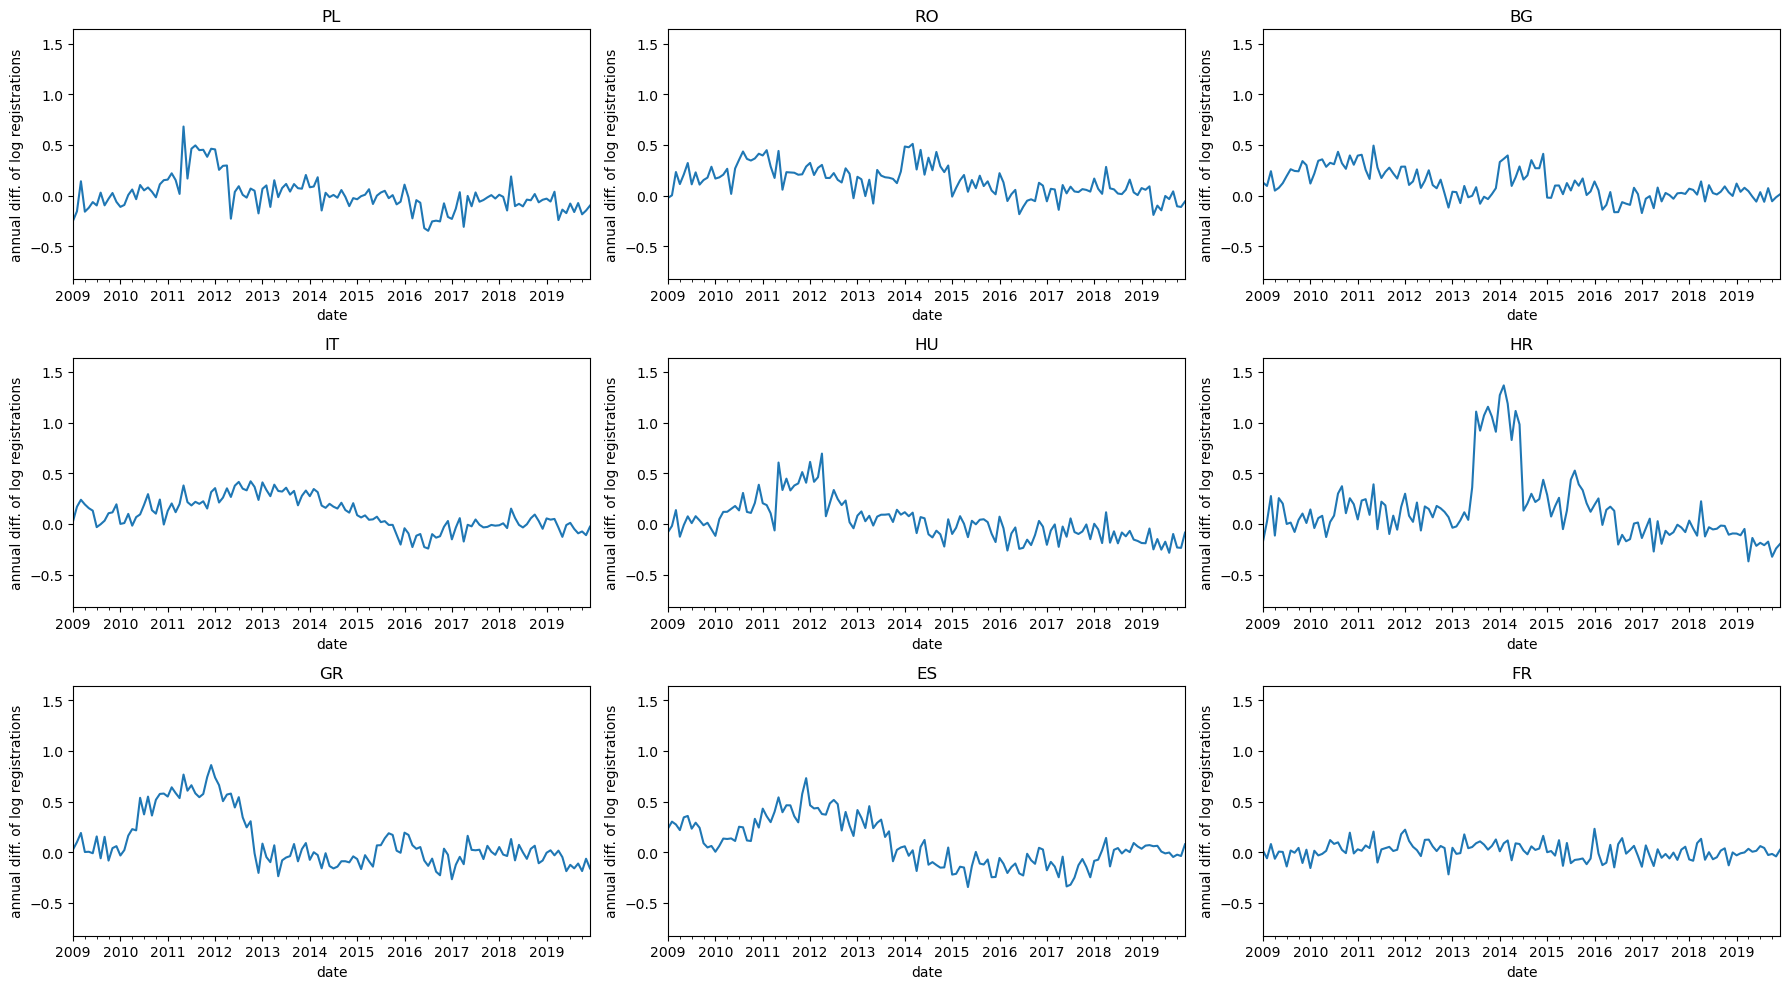

In [70]:
eumf_eval.plot_panel(
    df_values_transformed,
    n_rows=3,
    n_cols=3,
    figsize=(18, 10),
    legend=None,
    ylabel="annual diff. of log registrations",
    countries=country_selection,
    global_autoscale=True,
)
plt.show()


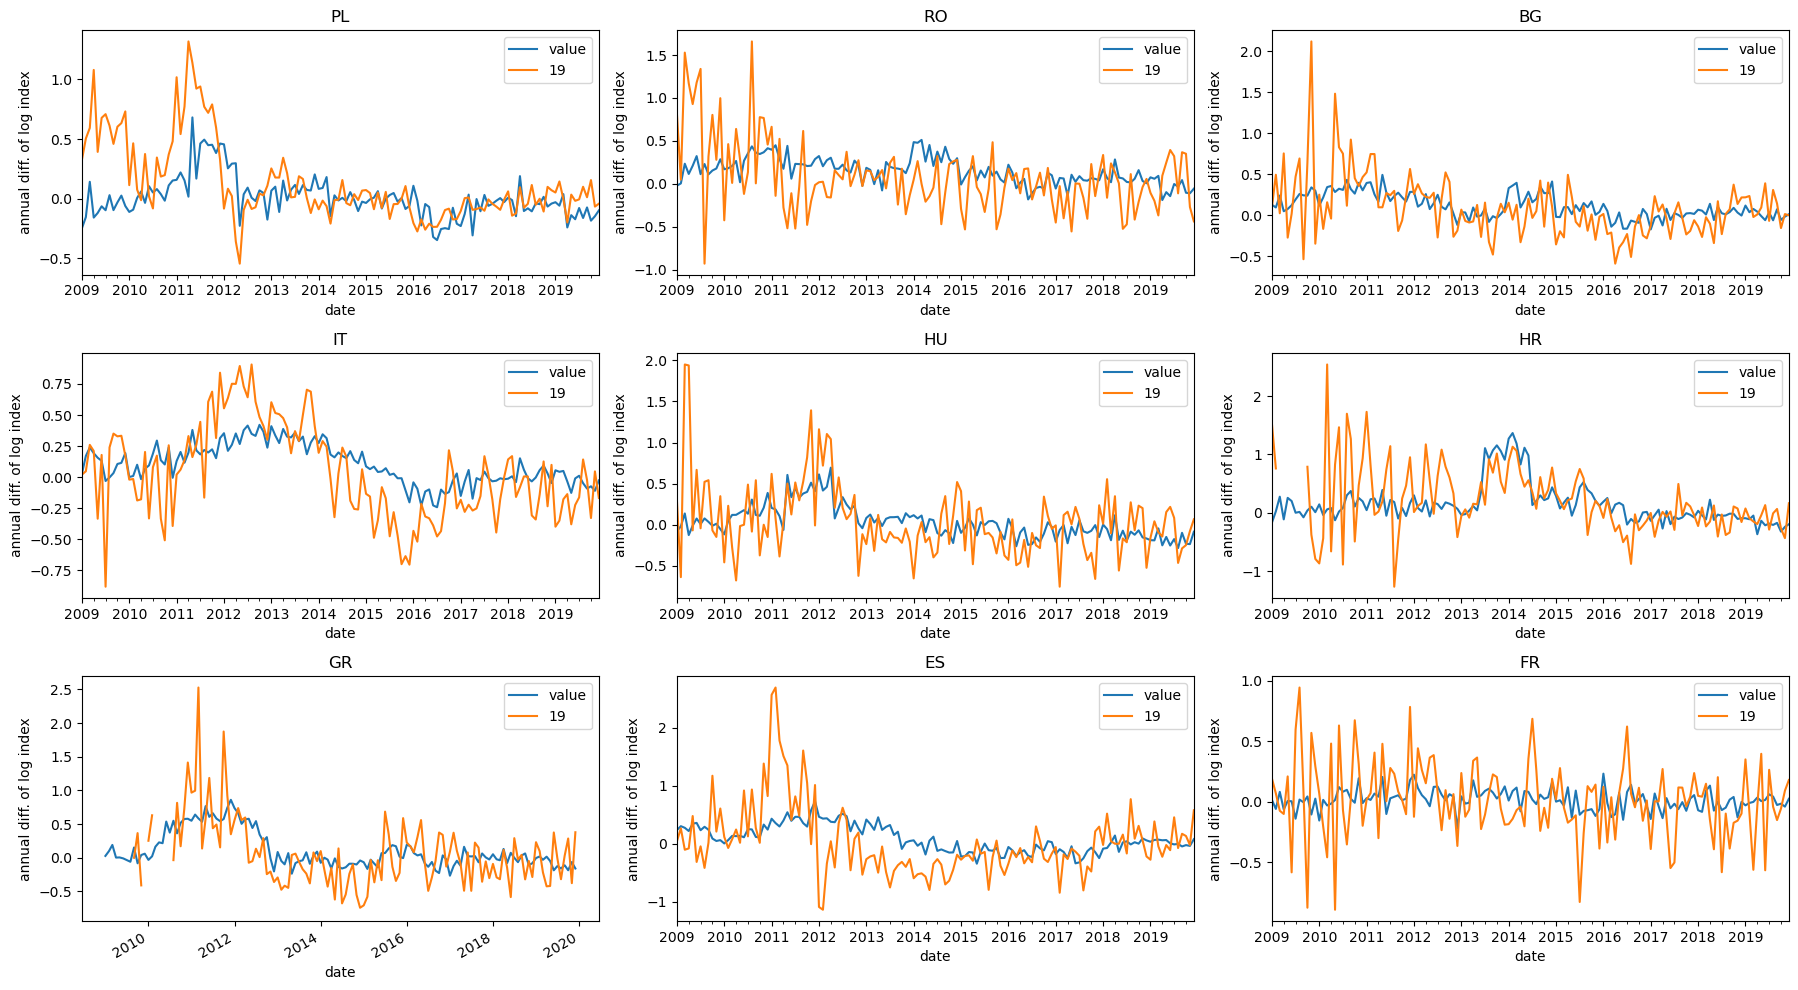

In [79]:
eumf_eval.plot_panel(
    panel_transformed[["value", "19"]],
    n_rows=3,
    n_cols=3,
    figsize=(18, 10),
    ylabel="annual diff. of log index",
    countries=country_selection,
)
plt.show()


In [120]:
def plot_crosscorrelation(
    trends,
    registrations,
    countries,
    n_cols=3,
    n_lags=24,
    t_min="2010",
    t_max="2019",
    figsize=None,
    v_min=None,
    v_max=None,
    x_label=None,
    y_label=None,
):

    n_rows = math.ceil(len(countries) / n_cols)

    if figsize is None:
        figsize = (8 * n_cols, 6 * n_rows)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):

            ax = axs[i, j]
            country = countries[i * n_cols + j]

            y = trends[country]
            x = registrations[country]

            cross_corr = sm.tsa.ccf(x[t_min:t_max], y[t_min:t_max])

            n = len(x[t_min:t_max])
            ci_u, ci_l = -1 / n + 2 / np.sqrt(n), -1 / n - 2 / np.sqrt(n)

            if v_min is not None and v_max is not None:
                ax.set_ylim(v_min, v_max)

            ax.vlines(range(n_lags), 0, cross_corr[:n_lags])
            ax.axhline(0, c="black", lw=2)
            ax.axhline(ci_u, ls="--", c="black")
            ax.axhline(ci_l, ls="--", c="black")

            if x_label is not None:
                ax.set_xlabel(x_label)

            if y_label is not None:
                ax.set_ylabel(y_label)

            ax.set_title(country)

    plt.tight_layout()
    return fig


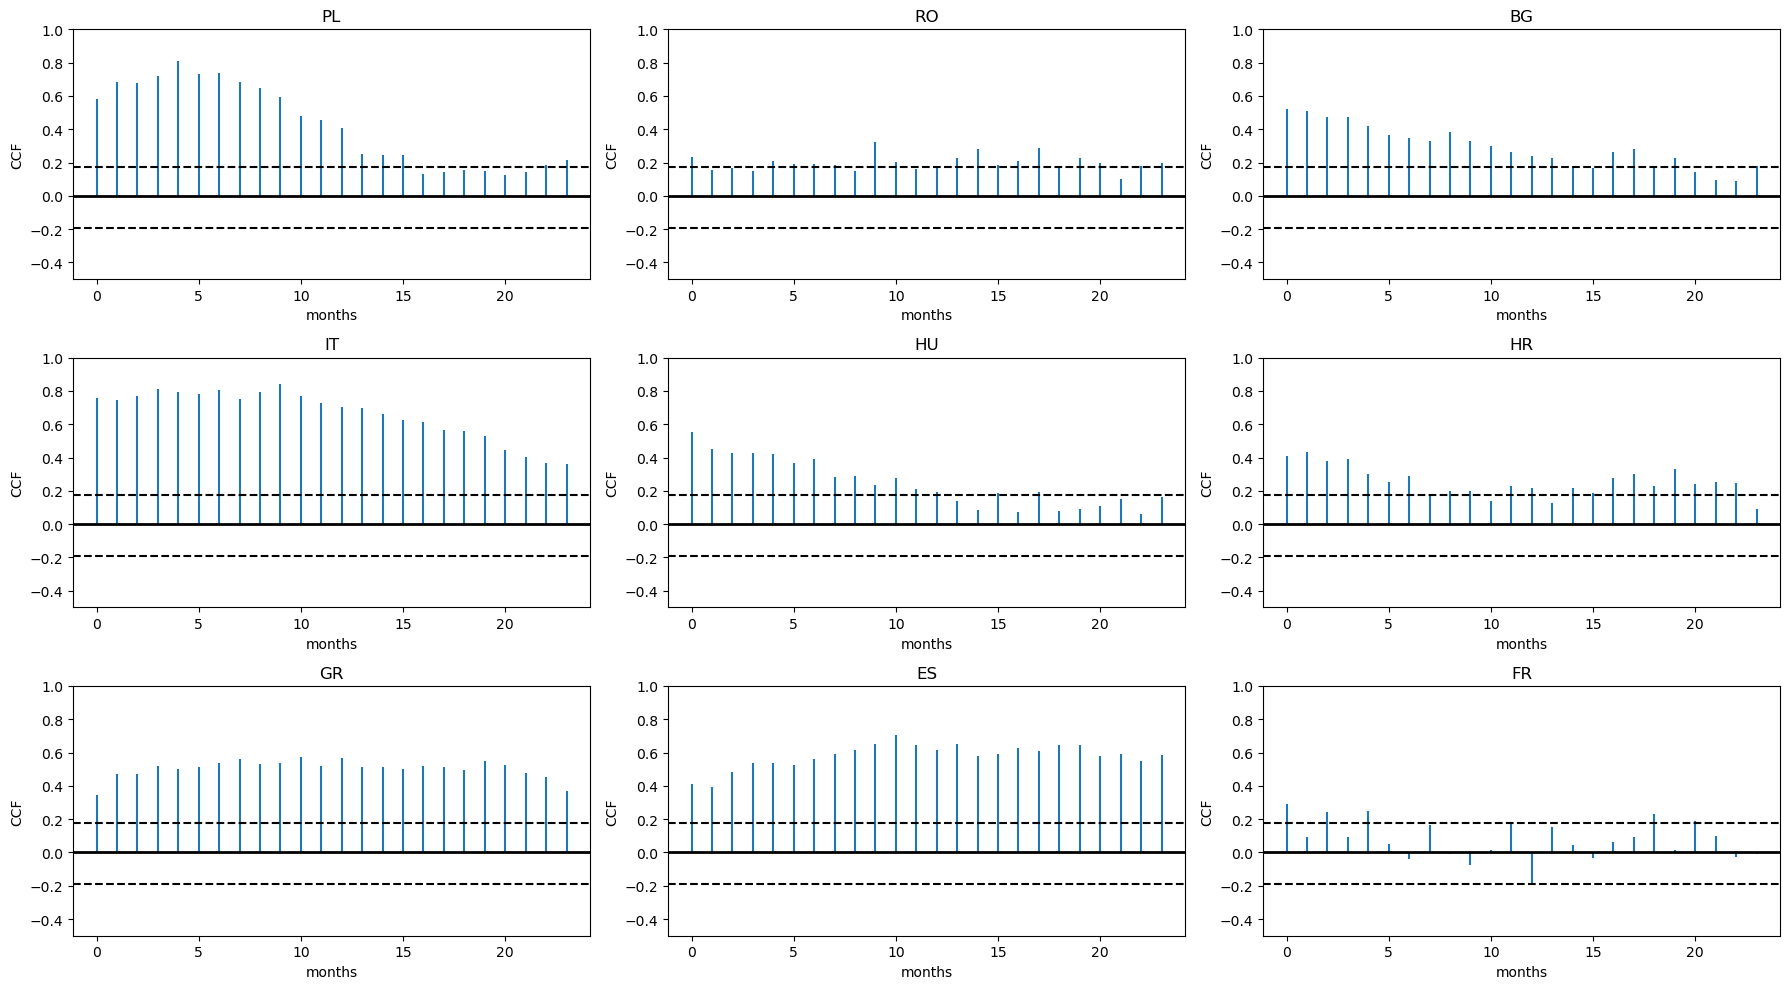

In [122]:
plot_crosscorrelation(
    panel_transformed["19"],
    panel_transformed["value"],
    country_selection,
    figsize=(18, 10),
    v_min=-0.5,
    v_max=1,
    x_label="months",
    y_label="CCF",
)

